## Computational Environment


In [1]:
using Pkg
Pkg.activate("hw9")
using Distributions
using DataFrames
using Plots
using DelimitedFiles
using LinearAlgebra
using Statistics
using ProtoStructs
using CSV
import Random
Random.seed!(2022)

  Activating project at `~/Documents/GitHub/STAT638_Applied-Bayes-Methods/hw/hw9`


Random.TaskLocalRNG()

## Description

- Course: STAT638, 2022 Fall
- Deadline: 2022/11/17, 12:00 pm

> Read Chapter 9 in the Hoff book. Then do Problems 9.1 and 9.2 in Hoff.
> 
> For both regression models, please include an intercept term ($\beta_0$).
> 
> In 9.1(b), please replace "max" by "min". (This is not listed in the official book errata, but appears to be a typo.)
> 
> For 9.2, the azdiabetes.dat data are described in *Exercise* 6 of Chapter 7 (see errata).

- Note: This PDF file is generated by Quarto and LualaTeX. There is unsolved problem to display the special character in the source code. Thus, I leave the html version here for reference that displays the complete source code: 

> [https://stchiu.quarto.pub/stat_638_hw_9/](https://stchiu.quarto.pub/stat_638_hw_9/)

## Problem 9.1

> Extrapolation: The file `swim.dat` contains data on the amount of time in seconds, it takes each of four high school swimmers to swim $50$ yards. Each swimmer has $6$ times, taken on a biweekly basis.

### (a)

> Perform the following data analysis for each swimmer separately:
> 
> 1. Fit a linear regression model of swimming time as the response and week as the explanatory variable. To formulate your prior, use the information that competitive times for this age group generally range from $22$ to $24$ seconds.
> 2. For each swimmer $j$, obtain a posterior predictive distribution for $Y^{*}_j$, their time if they were to swim $2$ weeks from the last recorded time.

- Suppose a linear model
$$Y = X\beta + \epsilon$$

$$Y_i = x_{i,1} \beta_1 + x_{i,2} \beta_2 + \epsilon_i$$

- $Y = \begin{bmatrix} Y_1\\  \vdots\\ Y_6\end{bmatrix}$. A swimmer's record of $6$. Series in time

- $X = \begin{bmatrix} x_{1,1} & x_{1,2}\\ \vdots & \vdots \\ x_{6,1} & x_{6,2} \end{bmatrix}$
  - $x_{j,1}$: $j$th record with swim score in the range of 22 to 24 second
  - $x_{j,2}$: Weeks of training

- $\beta = \begin{bmatrix} \beta_1 \\ \beta_2 \end{bmatrix}$. 
  - $\mu_0 = \begin{bmatrix} 23\\ 0 \end{bmatrix}$
    - The prior expectation of intercept of $y$ is $23$.
  - $\beta_0 \sim N_p(\mu_0, \Sigma_0)$.
    1. FCD: $\beta|y, \sigma^2 \sim N_p(\beta_n, \Sigma_n)$
    1. $\Sigma^{-1}_{n} = \Sigma^{-1}_{0} + \frac{X^T X}{\sigma^2}$
    2. $\beta_n = \Sigma_n (\Sigma^{-1}_{0} \beta_0 + \frac{X^T y}{\sigma^2})$ 

**Prior setting**

- $\Sigma_{0} = \begin{bmatrix} 0.1 & 0\\ 0 & 0.1 \end{bmatrix}$
  - There is uncertainty about $\beta$ estimation. 
  - Covariance of time and intersept is believe as $0$
- $\sigma^2 \sim IG(\nu_0/2 , \nu_0 \sigma^{2}_0 /2)$
  - FCD: $\sigma^2 |y,\beta \sim IG((\nu_0 + n)/2, (\nu_0\sigma^{2}_{0}) + SSR(\beta)/2)$
- $SSR(\beta) = (y - X\beta)^T (y-X\beta)$


In [2]:
ys = readdlm("data/swim.dat")

4×6 Matrix{Float64}:
 23.1  23.2  22.9  22.9  22.8  22.7
 23.2  23.1  23.4  23.5  23.5  23.4
 22.7  22.6  22.8  22.8  22.9  22.8
 23.7  23.6  23.7  23.5  23.5  23.4

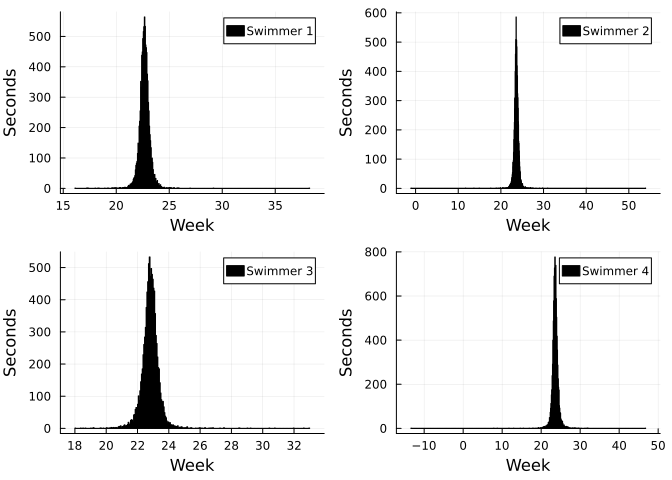

In [3]:
"""
Problem 9.1 (a)
"""

@proto struct SwimmingModel 
    S = 1000 # Number of sampling
    # Data
    y 
    n = length(y) # number of records
    # Model
    X = hcat( ones(n), collect(0:2:10) )
    p = size(X)[2]
    # Prior
    β₀ = MvNormal([23., 0.], [0.1 0; 0 0.1])
    ν₀ = 1.
    σ₀² = 0.2
end


function SSR(β, y, X)
    ssrV = (y - X*β)' * (y - X*β)
    return sum(ssrV)
end

function β_FCD(σ², m::SwimmingModel)
    Σₙ =( m.β₀.Σ^-1 + m.X' * m.X / σ²)^-1
    μₙ = Σₙ*(m.β₀.Σ^-1 * m.β₀.μ + m.X' * m.y / σ²)
    return MvNormal(vec(μₙ), Hermitian(Σₙ))
end

function σ²_FCD(β, m::SwimmingModel)
    α = (m.ν₀ + m.n)/2
    θ = (m.ν₀*m.σ₀²) + SSR(β, m.y, m.X)
    return InverseGamma(α, θ)
end

function pred(X, m::SwimmingModel)
    # Sampling vector
    βsmp = zeros(m.S, length(m.β₀.μ))
    σ²smp = zeros(m.S)
    y = zeros(m.S)
    # Init
    βsmp[1,:] = rand(m.β₀)
    σ²smp[1] = m.σ₀²
    y[1] = m.y[1]
    for i in 2:m.S 
        βsmp[i,:] = rand(β_FCD(σ²smp[i-1], m))
        σ²smp[i] = rand(σ²_FCD(βsmp[i-1,:], m))

        # Predict 
        y[i] = βsmp[i,:]' * X + rand(Normal(0., σ²smp[i]))
    end

    return (y=y, β=βsmp, σ²=σ²smp)
end

j_swim = 1
ms = [ SwimmingModel(y = hcat(ys[i,:]), S=10000 ) for i in 1:size(ys)[1] ]
ys_pred = zeros(size(ys)[1], ms[1].S) 
X_pred = [1,12]

for i in eachindex(ms)
    ys_pred[i,:] = pred([1,12], ms[i]).y
end

## Plotting
p = [histogram(ys_pred[i,:], label="Swimmer $i", color="black",
    xlabel="Week", ylabel="Seconds"
    ) for i in 1:size(ys)[1]]
plot(p...)

### (b)

> The coach of the team has to decide which of the four swimmers will compete in a swimming meet in $2$ weeks. Using your predictive distributions, compute $Pr(Y^{*}_{j} = \max\{Y^{*}_1,\dots, Y^{*}_4\}|Y)$ for each swimmer $j$, and based on this make a recommendation to the coach.


In [4]:
am = argmax(ys_pred, dims=1)

y_count = zeros(1, size(ys)[1])

for a in am 
    y_count[a[1]] += 1
end

pmax = vec(y_count ./ length(am))

## Recommendation
ds = DataFrame( Dict("Swimmer"=> collect(1:size(ys)[1]),"Pr(Y_i is max)" => pmax ))

Row,Pr(Y_i is max),Swimmer
,Float64,Int64
1,0.023,1
2,0.4773,2
3,0.0424,3
4,0.4573,4


In [5]:
#| echo: false
print("Swimmer $(argmax(pmax)[1]) is the most probable winner.")

Swimmer 2 is the most probable winner.

## Problem 9.2

> Model selection: As described in Example 6 of Chapter 7, the file `azdiabetes.dat` contains data on health-related variables of a population of $532$ women. In this exercise we will be modeling the conditional distribution of glucose level (`glu`) as a linear combination of the other variables, excluding the variable `diabetes`.




### (a)

> Fit a regression model using the $g$-prior with $g=n$, $\nu_0 =2$ and $\sigma^{2}_{0} = 1$. Obtain posterior confidence intervals for all of the parameters.


In [6]:
data = readdlm("data/azdiabetes.dat")

533×8 Matrix{Any}:
   "npreg"     "glu"    "bp"    "skin"    "bmi"   "ped"    "age"  "diabetes"
  5          86       68      28        30.2     0.364   24       "No"
  7         195       70      33        25.1     0.163   55       "Yes"
  5          77       82      41        35.8     0.156   35       "No"
  0         165       76      43        47.9     0.259   26       "No"
  0         107       60      25        26.4     0.133   23       "No"
  5          97       76      27        35.6     0.378   52       "Yes"
  3          83       58      31        34.3     0.336   25       "No"
  1         193       50      16        25.9     0.655   24       "No"
  3         142       80      15        32.4     0.2     63       "No"
  2         128       78      37        43.3     1.224   31       "Yes"
  0         137       40      35        43.1     2.288   33       "Yes"
  9         154       78      30        30.9     0.164   45       "No"
  ⋮                                             

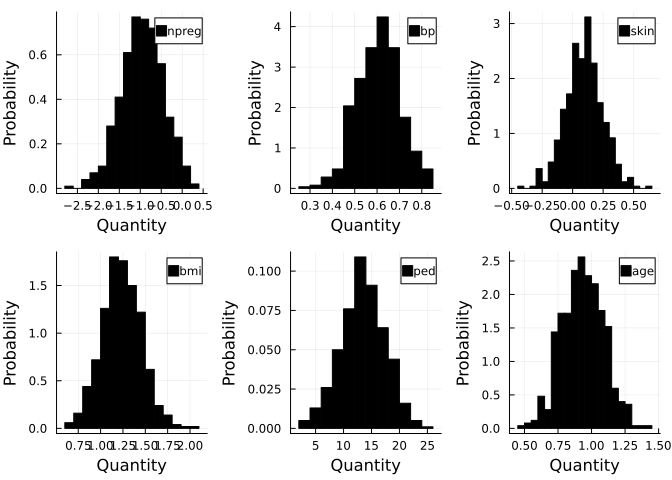

In [7]:
dt = data[1:end , 1:end-1]
y = float.(dt[2:end, 2])
X = float.(dt[2:end, 1:end .!= 2])
ns = data[1,1:end-1]
ns = ns[1:end .!=2]

@proto struct DiabetesModel 
    S = 500 # Number of sampling
    # Data
    y 
    X
    n = length(y) # number of records
    p = size(X)[2]
    # Model 
    # Prior
    g = n # g prior
    ν₀ = 2.
    σ₀² = 1.
end

function β_FCD(σ², m::DiabetesModel)
    return β_FCD(σ², m.g, m.X, m.y)
end

function β_FCD(σ², g, X, y)
    Σₙ = g/(g+1) * σ² * (X'X)^-1
    μₙ = g/(g+1) * β̂(σ², y, X)
    βₙ =  MvNormal(μₙ, Hermitian(Σₙ))
    return βₙ    
end

function β̂(σ², y, X)
    return σ² * (X'X)^-1 * (X'y / σ²)
end



function σ²_FCD(m::DiabetesModel)
    return σ²_FCD(m.ν₀, m.σ₀², m.n, m.X, m.y, m.g)
end

function σ²_FCD(ν₀, σ₀², n, X, y, g)
    α = ν₀ + n / 2.
    θ = (ν₀ * σ₀² + SSR(X, y, g))/2.
    σ² = InverseGamma(α, θ)
    return σ²
end

function SSR(m::DiabetesModel)
    return SSR(m.X, m.y, m.g)
end

function SSR(X, y, g)
    return y'*(I - g/(g+1)*X*(X'X)^-1*X')*y
end


m = DiabetesModel(y=y, X=X )
σ²smp = zeros(m.S, 1)
βsmp = zeros(m.S, size(m.X)[2])

for i in 1: m.S
    σ²smp[i] = rand(σ²_FCD(m))
    βsmp[i,:] = rand(β_FCD(σ²smp[i], m))
end

ps = [histogram(βsmp[:,i], xlabel="Quantity", 
      ylabel="Probability",normalize=true, label="$(ns[i])", color="black") 
      for i in 1:m.p]
plot(ps...)

### (b)

> Perform the model selection and averaging procedure described in Section 9.3. Obtain $Pr(\beta_j \neq 0 |y)$, as well as posterior confidence intervals for all of the parameters. Compare to the results in part (a).

$$\{y|X_{z(k)},\beta_{z(k)}, \sigma^2\} \sim \text{ multivariate normal }(X_{z(k)}\beta_{z(k)}, \sigma^2 I)$$


In [8]:
m = DiabetesModel(y=y, X=X,  S=1000)


function σ²_FCD(m::DiabetesModel, zs)
    Xz = @view m.X[1:end, Bool.(zs)]
    return σ²_FCD(m.ν₀, m.σ₀², m.n, Xz, m.y, m.g)
end

function β_FCD(σ², m::DiabetesModel, zs)
    Xz  = @view m.X[1:end, Bool.(zs)]
    return β_FCD(σ², m.g, Xz, m.y)
end

function y_margin(σz², m::DiabetesModel, zs)
    ν₀ = m.ν₀
    n = m.n
    y = m.y 
    g = m.g
    pz = sum(zs)
    Xz  = @view m.X[1:end, Bool.(zs)]
    ssr = SSR(Xz, y, g)

    pyl = -(pz/2.)log(1. +g) + (ν₀/2.)*log(σz²) - ((ν₀+n)/2)*log((ν₀*σz² + ssr))
    return pyl
end

function z_FCD(i , σz², zsmp, nSmp,m::DiabetesModel)
    zs = zsmp[nSmp,:]
    pj1 = sum(zsmp[1:nSmp, i]) / length(zsmp[1:nSmp, i])
    pj0 = 1. - pj1
    pj1_FCD_l =  pj1 * y_margin(σz², m, ones(length(zs)))
    pj0_FCD_l =  pj0 * y_margin(σz², m, zs)
    O = exp(pj0_FCD_l - pj1_FCD_l)
    return Bernoulli( 1/(1+O))
end


zsmp = ones(m.S, size(m.X)[2])
σ²smp = zeros(m.S, 1)
βsmp = zeros(m.S, size(m.X)[2])

σ²smp[1] = 0.1
# Gibbs sampling
for i in 2:m.S
    for j in Random.shuffle(1:m.p)
        zp = z_FCD(j, σ²smp[i-1], zsmp, i-1, m)
        zsmp[i, j] = rand(zp)
    end

    σ²smp[i] = rand(σ²_FCD(m, zsmp[i,:]))
    βsmp[i, Bool.(zsmp[i,:])] = rand(β_FCD(σ²smp[i], m, zsmp[i,:]))
end




sum(zsmp, dims=1)/size(zsmp)[1]
prB = 1. .- vec(sum(zsmp, dims=1))./size(zsmp)[1]
DataFrame(Dict( "Bi"=> ns, "Pr(Bi != 0 |y)"=> prB ))

Row,Bi,Pr(Bi != 0 |y)
,Any,Float64
1,npreg,0.499
2,bp,0.499
3,skin,0.499
4,bmi,0.499
5,ped,0.499
6,age,0.5


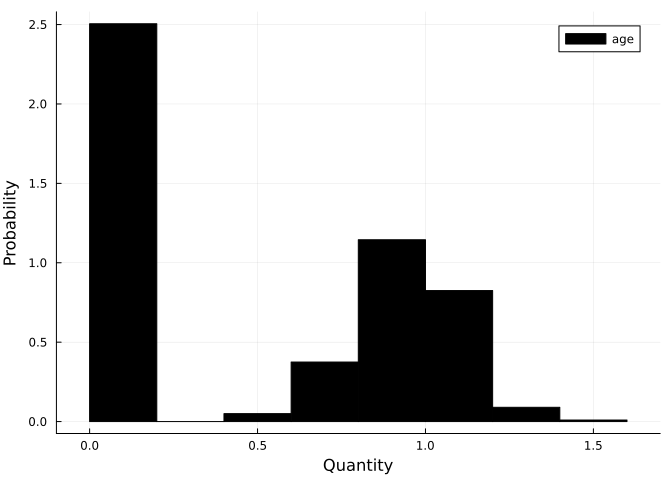

In [9]:
inds = prB .>= 0.5
b_select = prB[inds]
ps = [histogram(βsmp[:, i], xlabel="Quantity", 
      ylabel="Probability",normalize=true, label="$(ns[i])", color="black") 
      for i in  findall(inds .== 1)]
plot(ps...)

In [10]:
DataFrame(Dict("Parameters"=> ns[inds], 
               "Confidence interval"=> [quantile(βsmp[:,i], [0.25, 0.975]) for i in  findall(inds .== 1)]))

Row,Confidence interval,Parameters
,Array…,Any
1,"[0.0, 1.1847]",age


**Conclusion**

There might be some bugs in FCD formulation. The current results show that all the features are equally important after model selection. The distribution is far different from what it is in part (a).